# Reservoir level data analysis

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from mizani.breaks import date_breaks
from statsmodels.tsa.seasonal import STL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

In [2]:
raw_data = pd.read_csv('../data/raw/datos-de-cotas-y-niveles-de-embalses-reales.tsv', sep='\t', decimal=',', parse_dates=['fecha'])
raw_data.head()

,nombre_embalse,fecha,hora,cota
0,ANGOSTURA,2022-01-01,1,316.42
1,CHAPO,2022-01-01,1,234.57
2,COLBUN,2022-01-01,1,430.00
3,INVERNADA,2022-01-01,1,1293.18
4,LAJA,2022-01-01,1,1319.33


In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113056 entries, 0 to 113055
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   nombre_embalse  113056 non-null  object        
 1   fecha           113056 non-null  datetime64[ns]
 2   hora            113056 non-null  int64         
 3   cota            113056 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.5+ MB


In [4]:
# Reservoir unique categories
reserovir_list = raw_data['nombre_embalse'].unique()
reserovir_list

array(['ANGOSTURA', 'CHAPO', 'COLBUN', 'INVERNADA', 'LAJA', 'MACHICURA',
       'MAULE', 'MELADO', 'PANGUE', 'POLCURA', 'RALCO', 'RAPEL'],
      dtype=object)

In [5]:
# Timestamp analysis
raw_data['fecha'].min(), raw_data['fecha'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-01-28 00:00:00'))

In [6]:
raw_data['hora'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [7]:
# Pivot table
raw_data_long = raw_data.pivot(
    index=['fecha', 'hora'],
    columns=['nombre_embalse'],
    values='cota'
) \
    .reset_index() 

raw_data_long.tail()

nombre_embalse,fecha,hora,ANGOSTURA,CHAPO,COLBUN,INVERNADA,LAJA,MACHICURA,MAULE,MELADO,PANGUE,POLCURA,RALCO,RAPEL
9417,2023-01-28,10,316.55,234.20,425.96,1307.81,1321.19,257.19,2160.19,641.28,507.55,735.73,713.84,103.72
9418,2023-01-28,11,316.56,234.19,425.95,1307.81,1321.19,257.17,2160.19,641.36,507.56,735.53,713.85,103.72
9419,2023-01-28,12,316.55,234.19,425.95,1307.81,1321.19,257.13,2160.19,641.43,507.55,735.34,713.85,103.72
9420,2023-01-28,13,316.54,234.18,425.95,1307.81,1321.19,257.10,2160.19,641.49,NaN,NaN,NaN,103.72
9421,2023-01-28,14,316.53,234.18,NaN,1307.81,1321.19,NaN,2160.19,641.56,NaN,NaN,NaN,103.72


In [8]:
# drop nans values
raw_data_long = raw_data_long.dropna()
raw_data_long.tail()

nombre_embalse,fecha,hora,ANGOSTURA,CHAPO,COLBUN,INVERNADA,LAJA,MACHICURA,MAULE,MELADO,PANGUE,POLCURA,RALCO,RAPEL
9415,2023-01-28,8,316.53,234.20,425.96,1307.80,1321.19,257.34,2160.19,641.05,507.57,735.91,713.84,103.72
9416,2023-01-28,9,316.53,234.20,425.96,1307.81,1321.19,257.25,2160.19,641.16,507.58,735.84,713.84,103.72
9417,2023-01-28,10,316.55,234.20,425.96,1307.81,1321.19,257.19,2160.19,641.28,507.55,735.73,713.84,103.72
9418,2023-01-28,11,316.56,234.19,425.95,1307.81,1321.19,257.17,2160.19,641.36,507.56,735.53,713.85,103.72
9419,2023-01-28,12,316.55,234.19,425.95,1307.81,1321.19,257.13,2160.19,641.43,507.55,735.34,713.85,103.72


In [9]:
# Deeling with daylight saving time using UTC timestamps
raw_data_long['timestamp'] = raw_data_long['fecha'] + pd.to_timedelta(raw_data_long['hora'], unit='h')
raw_data_long.head()

nombre_embalse,fecha,hora,ANGOSTURA,CHAPO,COLBUN,INVERNADA,LAJA,MACHICURA,MAULE,MELADO,PANGUE,POLCURA,RALCO,RAPEL,timestamp
0,2022-01-01,1,316.42,234.57,430.00,1293.18,1319.33,256.75,2161.08,641.44,509.78,735.27,720.10,104.0,2022-01-01 01:00:00
1,2022-01-01,2,316.42,234.57,429.99,1293.18,1319.33,256.80,2161.10,641.45,509.86,735.26,720.10,104.0,2022-01-01 02:00:00
2,2022-01-01,3,316.44,234.57,429.97,1293.16,1319.33,256.88,2161.08,641.45,509.85,735.27,720.09,104.0,2022-01-01 03:00:00
3,2022-01-01,4,316.45,234.57,429.97,1293.14,1319.33,256.90,2161.08,641.46,509.82,735.20,720.09,104.0,2022-01-01 04:00:00
4,2022-01-01,5,316.46,234.57,429.96,1293.12,1319.33,256.91,2161.08,641.47,509.78,735.16,720.09,104.0,2022-01-01 05:00:00


In [10]:
# Deeling with daylight saving time using UTC timestamps
raw_data_long['timestamp'] = (pd.to_datetime(raw_data_long['timestamp'])
                                .dt.tz_localize('America/Santiago', ambiguous='NaT', nonexistent='NaT')
                                .dt.tz_convert('UTC'))

# Drop nonexistent timestamp
raw_data_long = raw_data_long.dropna()

# Drop non necesary columns
raw_data_long = raw_data_long.drop(['fecha', 'hora'], axis = 1)

# Remove duplicated timestamps
raw_data_long = raw_data_long.set_index('timestamp')
raw_data_long = raw_data_long.groupby(raw_data_long.index).first()

In [11]:
raw_data_long.index.is_unique

True

In [12]:
raw_data_long = raw_data_long.reset_index()
raw_data_long['date_check'] = raw_data_long['timestamp'].diff()
raw_data_long.date_check.value_counts()

0 days 01:00:00    9414
0 days 03:00:00       1
0 days 02:00:00       1
Name: date_check, dtype: int64

In [13]:
raw_data_long = raw_data_long.set_index('timestamp') \
             .resample('H') \
             .mean() \
             .interpolate() \
             .reset_index()

/tmp/ipykernel_392526/2705234428.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


## Data Visualization

In [14]:
# Prepare panel data
reservoir_list = raw_data['nombre_embalse'].unique()
panel_data = pd.melt(raw_data_long,
                     id_vars='timestamp',
                     value_vars=reservoir_list,
                     var_name='nombre_embalse',
                     value_name = 'cota')

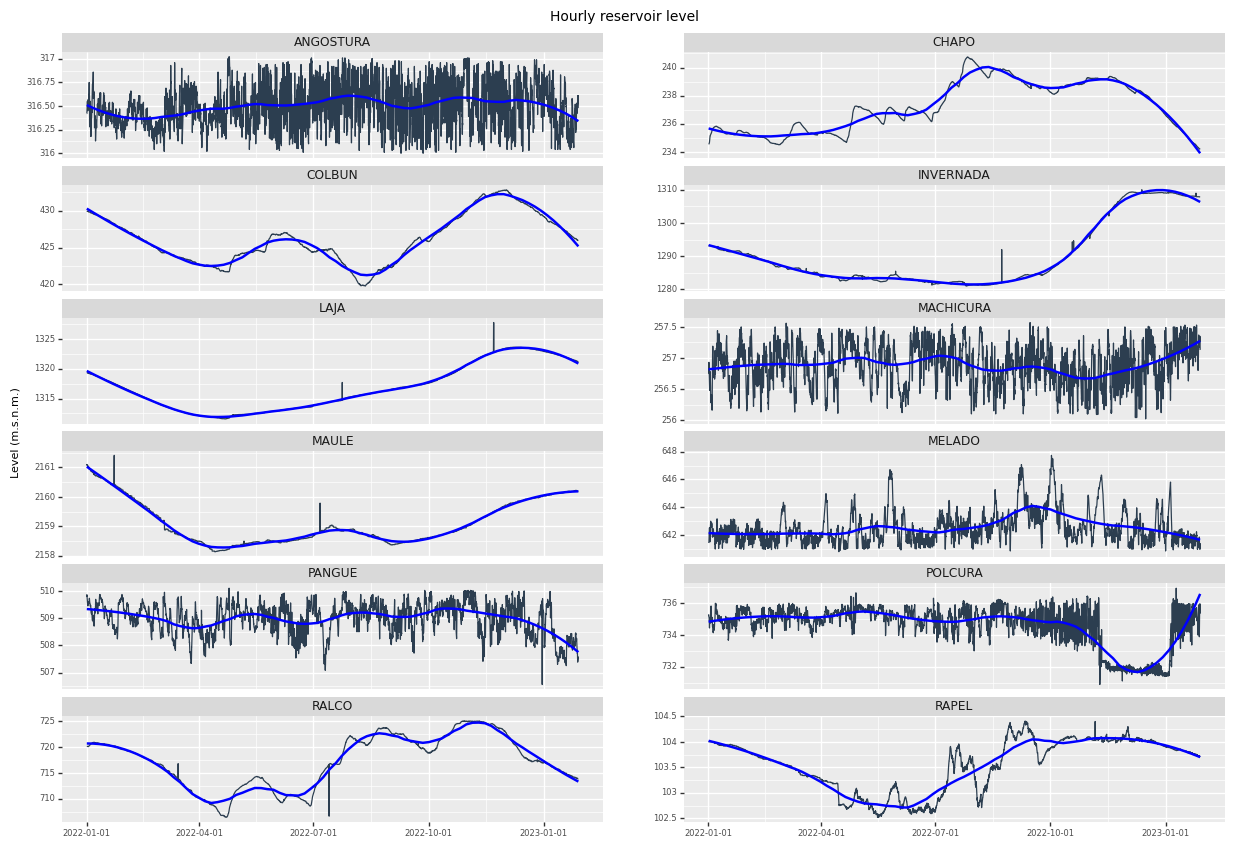

<ggplot: (8781513206547)>

In [15]:
## Plot time series
ggplot(data = panel_data, mapping = aes(x="timestamp", y="cota")) + \
    geom_line(color = "#2C3E50") + \
    geom_smooth(method = "loess",
                se = False,
                color = "blue",
                span = 0.3) + \
    facet_wrap(facets="nombre_embalse",
               ncol=2, scales = "free_y") + \
    scale_x_datetime(
        breaks = date_breaks("3 month")
    ) + \
    labs(
        title = "Hourly reservoir level",
        x = "",
        y = "Level (m.s.n.m.)"
    ) + \
    theme(subplots_adjust={"wspace": 0.15},
          axis_text_y = element_text(size = 6),
          axis_text_x = element_text(size = 6),
          plot_title  = element_text(size = 10),
          axis_title_y= element_text(size=8),
          figure_size=(15,10))


In [16]:
# Save dataset
panel_data.to_csv('../data/processed/reservoir_data_hourly.csv', index=False)

## Time series analysis

In [48]:
# STL decomposition
selection = 'RALCO'

emb_df = panel_data.query('nombre_embalse == @selection') \
                   .reset_index(drop=True) \
                   .set_index('timestamp') \
                   .asfreq('H') \
                   .sort_index()

In [49]:
# Plot STL decomposition
res = STL(emb_df['cota'], robust = True).fit()
seasonal, trend, resid = res.seasonal, res.trend, res.resid

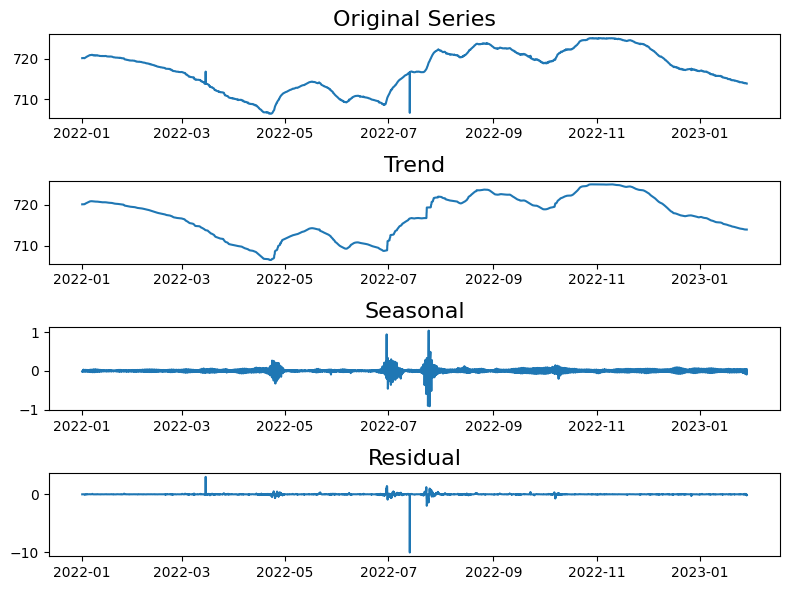

In [50]:
plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(emb_df['cota'])
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [51]:
# Trend analysis
y = emb_df['cota']
x = np.arange(0, len(y))

res = lowess(endog = y, exog = x, frac = 0.1, it = 3)
emb_df["lowess"] = res[:,1]
emb_df.head()

,nombre_embalse,cota,lowess
timestamp,,,
2022-01-01 04:00:00+00:00,RALCO,720.10,720.878788
2022-01-01 05:00:00+00:00,RALCO,720.10,720.877622
2022-01-01 06:00:00+00:00,RALCO,720.09,720.876456
2022-01-01 07:00:00+00:00,RALCO,720.09,720.875287
2022-01-01 08:00:00+00:00,RALCO,720.09,720.874118


Text(0.5, 0, 'Time')

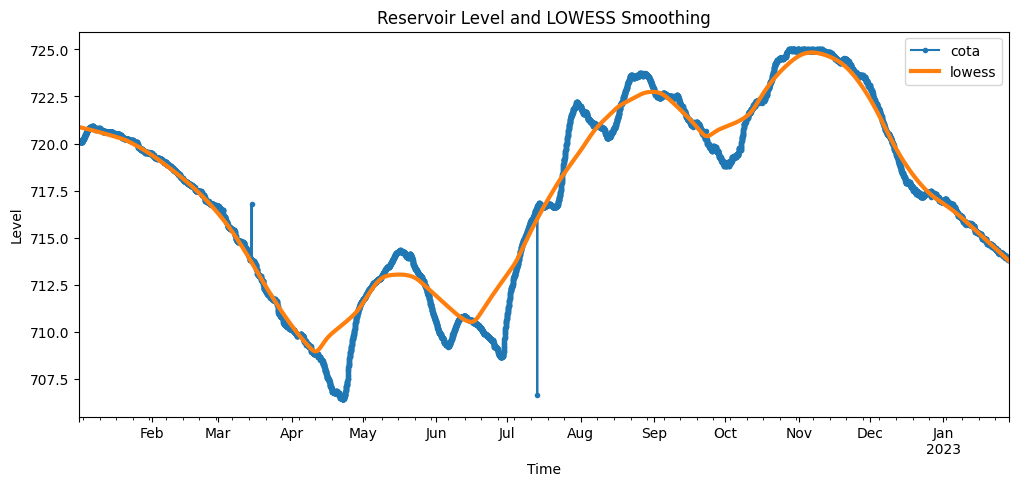

In [52]:
# Plot the fit
fig, ax = plt.subplots(figsize=[12, 5])
emb_df.plot(y="cota", marker=".", ax=ax)
emb_df.plot(y="lowess", ax=ax, linewidth=3)
ax.set_title("Reservoir Level and LOWESS Smoothing")
ax.set_ylabel("Level")
ax.set_xlabel("Time")

Text(0.5, 0.98, '')

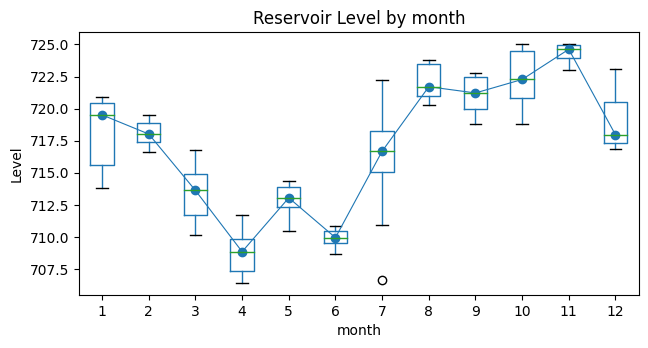

In [53]:
# Seasonal analysis
## Monthly seasonality

fig, ax = plt.subplots(figsize=(7, 3.5))
emb_df['month'] = emb_df.index.month
emb_df.boxplot(column='cota', by='month', ax=ax)
emb_df.groupby('month')['cota'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Level')
ax.set_title('Reservoir Level by month')
fig.suptitle('')

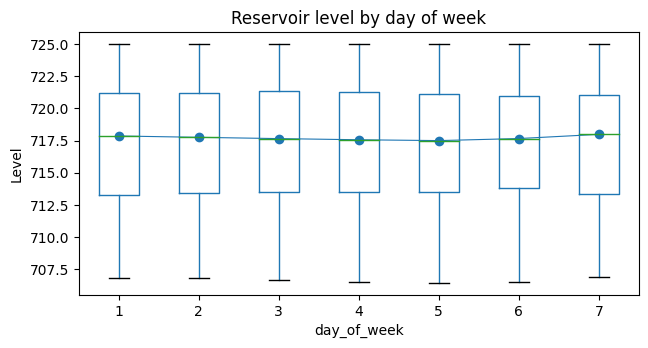

In [54]:
fig, ax = plt.subplots(figsize=(7, 3.5))
emb_df['day_of_week'] = emb_df.index.day_of_week + 1
emb_df.boxplot(column='cota', by='day_of_week', ax=ax)
emb_df.groupby('day_of_week')['cota'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Level')
ax.set_title('Reservoir level by day of week')
fig.suptitle('');

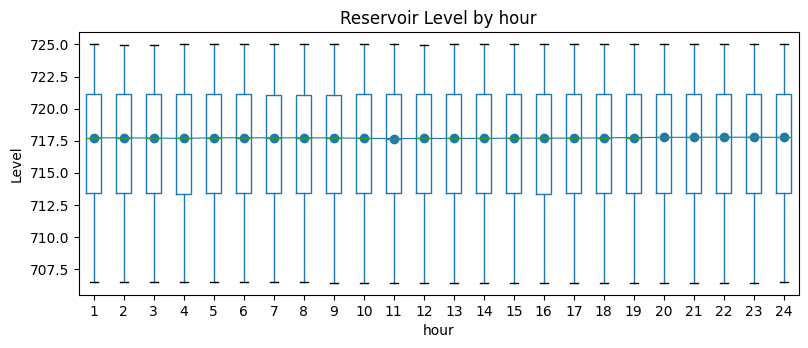

In [55]:
fig, ax = plt.subplots(figsize=(9, 3.5))
emb_df['hour'] = emb_df.index.hour + 1
emb_df.boxplot(column='cota', by='hour', ax=ax)
emb_df.groupby('hour')['cota'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Level')
ax.set_title('Reservoir Level by hour')
fig.suptitle('');

Text(0.5, 0, 'Lag')

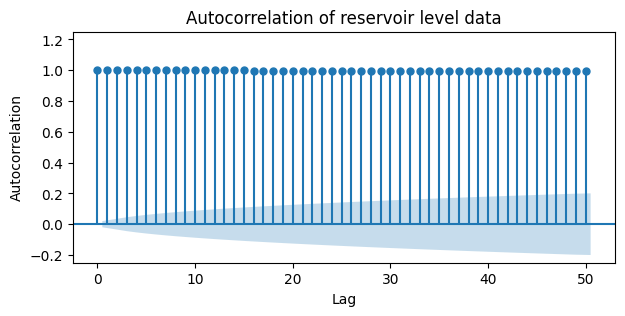

In [56]:
# Autocorrelation plot

fig, ax = plt.subplots(figsize=[7, 3])
plot_acf(
    x=emb_df.cota,
    lags=50,
    ax=ax,
    alpha=0.05,
    auto_ylims=True
);
ax.set_title("Autocorrelation of reservoir level data")
ax.set_ylabel("Autocorrelation")
ax.set_xlabel("Lag")

Text(0, 0.5, 'PACF')

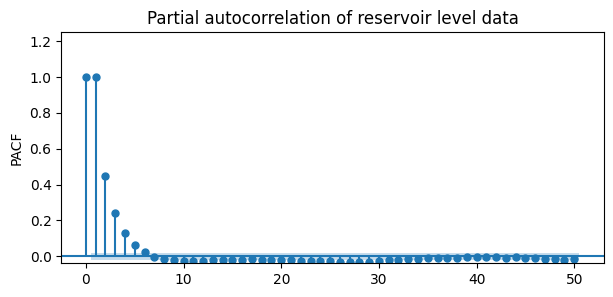

In [57]:
fig, ax = plt.subplots(figsize=[7, 3])
plot_pacf(
    x=emb_df.cota,
    lags=50,
    ax=ax,
    alpha=0.05,
    auto_ylims=True,
    method = "ywm"
);
ax.set_title("Partial autocorrelation of reservoir level data")
ax.set_ylabel("PACF")

In [58]:
# Test for stationarity
from statsmodels.tsa.stattools import adfuller 
X = emb_df.cota
result = adfuller(X) 
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) 
print('Critical Values:') 
for key, value in result[4].items(): print('\t%s: %.3f' % (key, value)) 
print('p> 0.05, La serie no es estacionaria')

ADF Statistic: -1.494683
p-value: 0.536140
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
p> 0.05, La serie no es estacionaria
